# **Questão 9.4**

Considere o problema de predição de uma série temporal definida como $x(n) = v(n) + \beta v(n-1)v(n-2)$, com média zero e variância dada por $\sigma_x^2 = \sigma_v^2 + \beta^2\sigma_v^2$, onde $v(n)$ é um ruído branco gaussiano, como variância unitária e $\beta=0.5$. Utilizando uma rede perceptrons de múltiplas camadas (feedfoward) estime $\hat{x}(n) = f(x(n-1),x(n-2),x(n-3),x(n-6),x(n-5),x(n-6))$ usando como entrada os seis últimos valores da série, isto é, no conjunto de treinamento utilize uma janela deslizante com as seis amostras anteriores. Isso correspode as entradas da rede neural. Avalie o desempenho mostrando a curva da série temporal, a curva de predição e a curva do erro da predição.

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense, Activation, BatchNormalization

In [15]:
# setting seed for reproducibility
np.random.seed(42)

# parameters
beta = 0.5
deviation = 1
n_samples = 10000

# generating white noise
v = np.random.normal(beta, deviation, n_samples)
x = v + beta*np.roll(v, -1)*np.roll(v, -2)

In [16]:
# splitting into training and test sets
test_size = 2000
x_train, x_test = x[:-test_size], x[-test_size:]

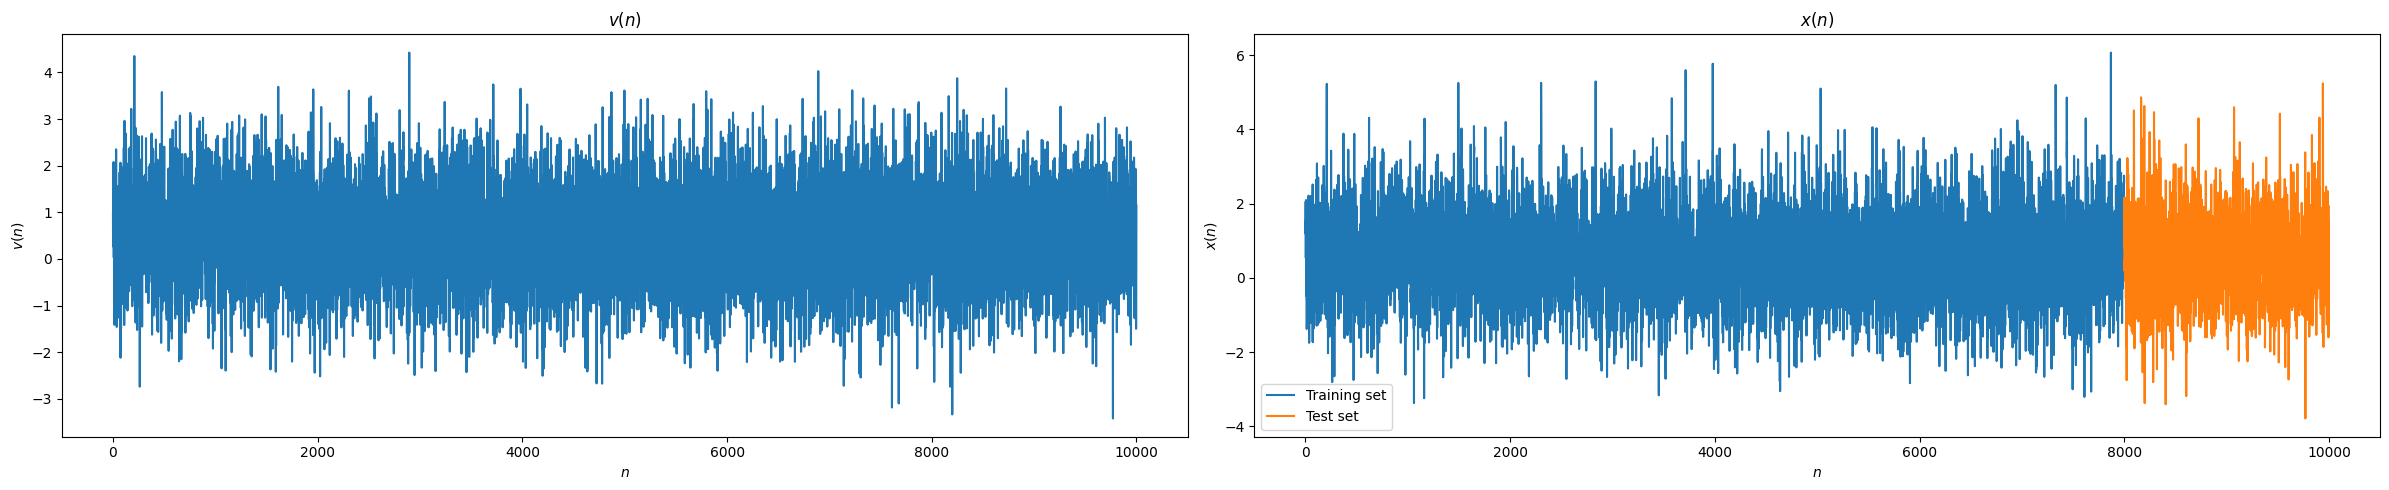

In [17]:
# plotting the data
fig, axes = plt.subplots(ncols=2, figsize=(24, 5))

axes[0].plot(v)
axes[0].set(
    title='$v(n)$',
    xlabel='$n$',
    ylabel='$v(n)$'
)

axes[1].plot(x_train, label='Training set')
axes[1].plot(np.arange(n_samples-test_size, n_samples), x_test,  label='Test set')

axes[1].legend()
axes[1].set(
    title='$x(n)$',
    xlabel='$n$',
    ylabel='$x(n)$'
)

plt.tight_layout()
plt.show()

In [18]:
# creating sequences for training dataset
lookback = 6
sequence_x = list(TimeseriesGenerator(x_train, x_train, lookback, batch_size=1))
sequence_y = list(TimeseriesGenerator(x_train[lookback:], x_train[lookback:], lookback, batch_size=1))

train_seqs = []
y_train = []
for (x_seq, next_x), (next_seq, _) in zip(sequence_x, sequence_y):
    seq = np.append(x_seq.reshape(lookback,), next_seq.reshape(lookback, ))
    
    train_seqs.append(seq)
    y_train.append(next_x)

train_seqs = np.array(train_seqs)
y_train = np.array(y_train)

In [19]:
# creating sequences for test dataset
sequence_x = list(TimeseriesGenerator(x_test, x_test, lookback, batch_size=1))
sequence_y = list(TimeseriesGenerator(x_test[lookback:], x_test[lookback:], lookback, batch_size=1))

test_seqs = []
y_test = []
for (x_seq, next_x), (next_seq, _) in zip(sequence_x, sequence_y):
    seq = np.append(x_seq.reshape(lookback,), next_seq.reshape(lookback, ))
    
    test_seqs.append(seq)
    y_test.append(next_x)

test_seqs = np.array(test_seqs)
y_test = np.array(y_test)

In [24]:
# defining the model
def get_model():
    model = Sequential()
    model.add(Dense(128, input_shape=(12, )))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(1))

    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=['mse']
    )
    
    return model

In [25]:
# checking the model summary
model = get_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               1664      
                                                                 
 activation_5 (Activation)   (None, 128)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 activation_6 (Activation)   (None, 64)                0         
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                      

In [26]:
history = model.fit(
    train_seqs, y_train,
    validation_data=(test_seqs, y_test),
    epochs=100,
    batch_size=32,
    verbose=1,
    shuffle=False,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)]
)

Epoch 1/100
250/250 [==============================] - 3s 6ms/step - loss: 0.4666 - mse: 0.4666 - val_loss: 0.1342 - val_mse: 0.1342 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.1677 - mse: 0.1677 - val_loss: 0.0463 - val_mse: 0.0463 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.1362 - mse: 0.1362 - val_loss: 0.0355 - val_mse: 0.0355 - lr: 0.0010
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.1225 - mse: 0.1225 - val_loss: 0.0306 - val_mse: 0.0306 - lr: 0.0010
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.1146 - mse: 0.1146 - val_loss: 0.0279 - val_mse: 0.0279 - lr: 0.0010
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.1089 - mse: 0.1089 - val_loss: 0.0261 - val_mse: 0.0261 - lr: 0.0010
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 0.1049 - mse: 0.1049 - val_loss: 0.0247 - val_mse

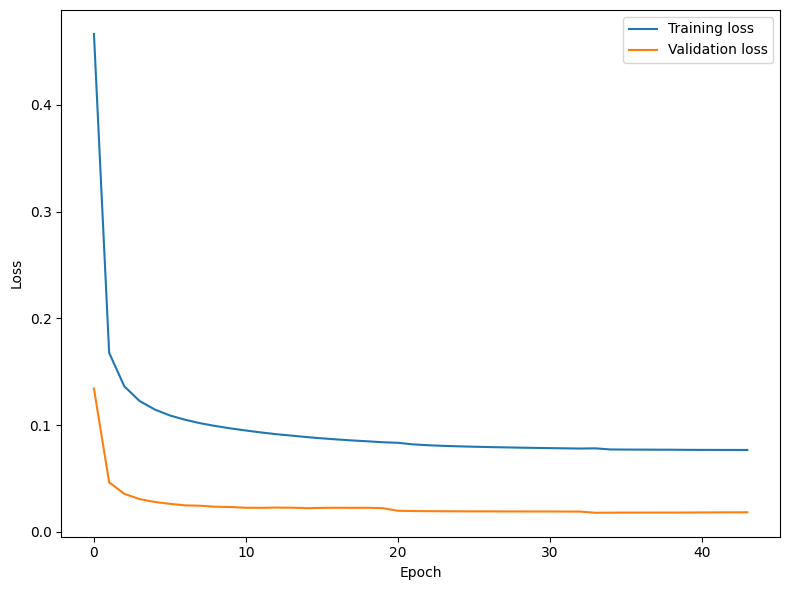

In [27]:
# plotting error curves
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Validation loss')

ax.legend()
ax.set(
    ylabel='Loss',
    xlabel='Epoch'
)

plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# making predictions
y_pred = model.predict(test_seqs)

63/63 [==============================] - 0s 2ms/step


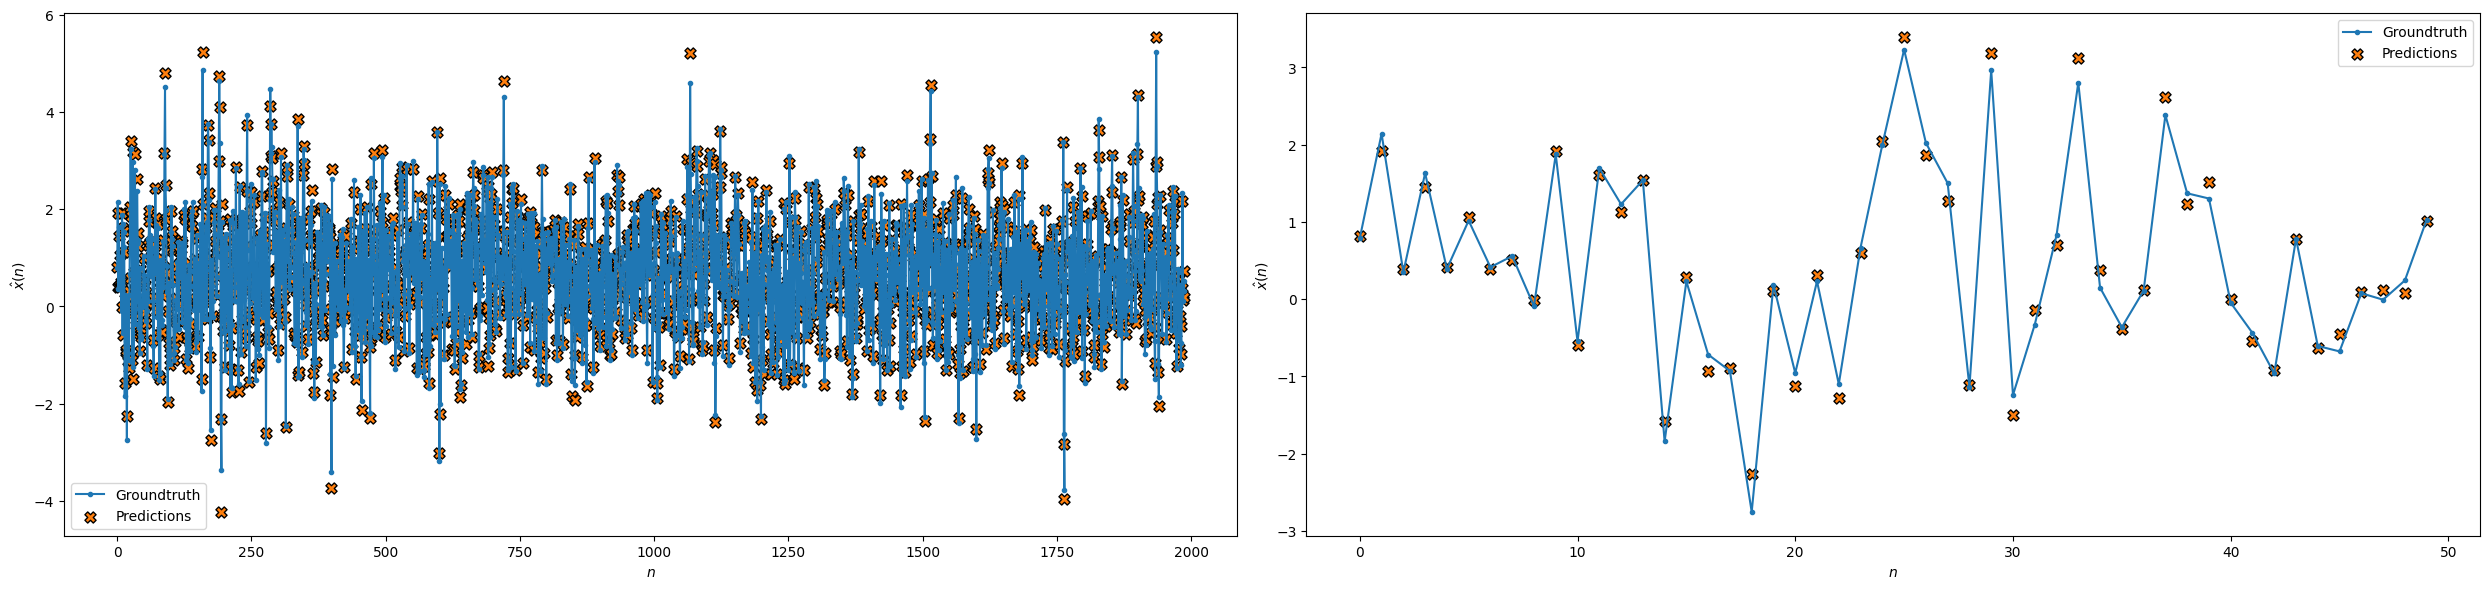

In [29]:
# plotting the predictions
fig, axes = plt.subplots(ncols=2, figsize=(25, 6))

axes[0].plot(y_test, marker='.', label='Groundtruth')
axes[0].scatter(
    range(len(y_pred)), y_pred, 
    marker='X', edgecolors='k', 
    label='Predictions', c='#ff7f0e', 
    s=64
)

axes[0].legend()
axes[0].set(
    ylabel='$\hat{x}(n)$',
    xlabel='$n$'
)

axes[1].plot(y_test[:50], marker='.', label='Groundtruth')
axes[1].scatter(
    range(len(y_pred[:50])), y_pred[:50], 
    marker='X', edgecolors='k', 
    label='Predictions', c='#ff7f0e', 
    s=64
)

axes[1].legend()
axes[1].set(
    ylabel='$\hat{x}(n)$',
    xlabel='$n$'
)

plt.tight_layout()
plt.show()

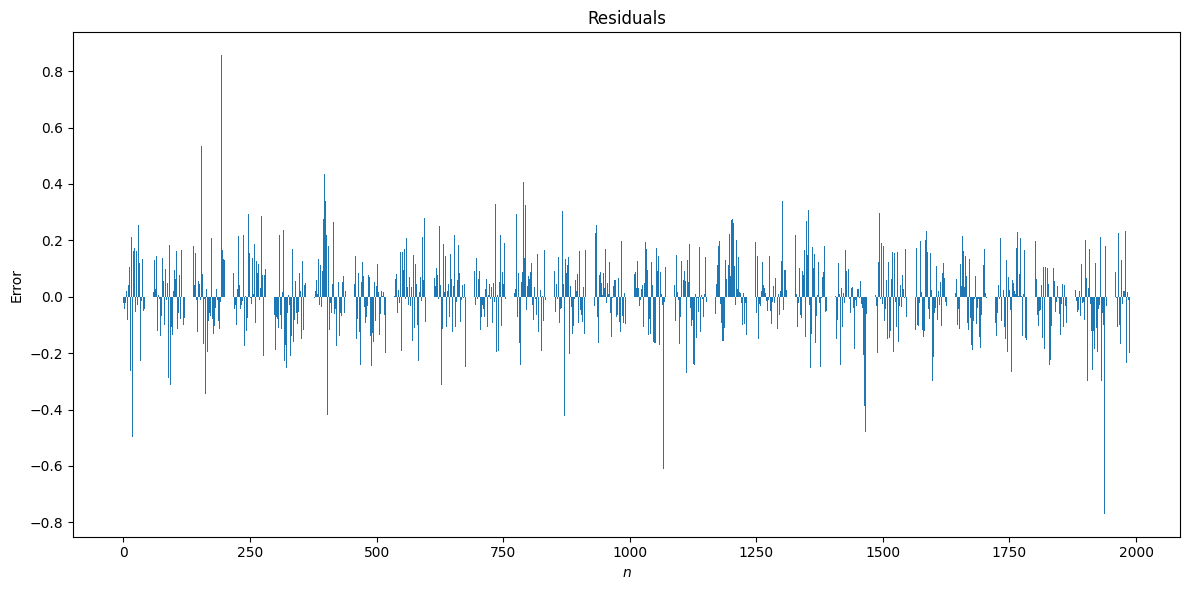

In [30]:
residuals = y_test - y_pred

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(
    x=range(len(residuals)),
    height=residuals.flatten()
)

ax.set(
    title='Residuals',
    xlabel='$n$',
    ylabel='Error'
)

plt.tight_layout()
plt.show()

In [32]:
# mean squared error
mse = np.mean(residuals**2)
print(f'Mean squared error: {mse}')

# mean absolute error
mae = np.mean(np.abs(residuals))
print(f'Mean absolute error: {mae}')

# root mean squared error
rmse = np.sqrt(mse)
print(f'Root mean squared error: {rmse}')

Mean squared error: 0.018185157168104062
Mean absolute error: 0.10244900960540838
Root mean squared error: 0.1348523532167832
